In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
import itertools
import random
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import torch.nn.utils.prune as prune
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import logging
from functools import partial
from collections import OrderedDict
import seaborn as sns
import matplotlib as mp
import time
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler



import importlib
import sys

sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation
from utils.models.VQ_VAE import Model
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

import json
from tqdm import tqdm


# instead, we plug in our OWN datasets

In [3]:
suggested_genes_file_1 = '../../data/PD_genes_of_interest/signif_de_Disease_status_IDIOPATHIC_PD_01.tsv'
suggested_genes_file_2 = '../../data/PD_genes_of_interest/signif_de_PD_DIAGNOSIS_0.1.tsv'

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  5 ...
min MAD 0.0
max MAD 4194.0


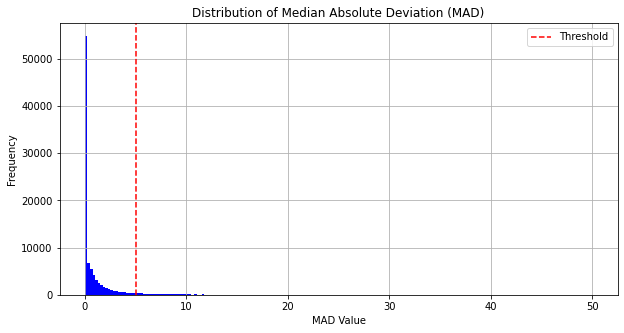

removing 89395 genes under the MAD threshold from the dataset
number of genes selected :  5914
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series
not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
retriving symbols for genes
selecting genes based on median absolute deviation threshold:  2 ...
min MAD 0.0
max MAD 4192.0999999999985


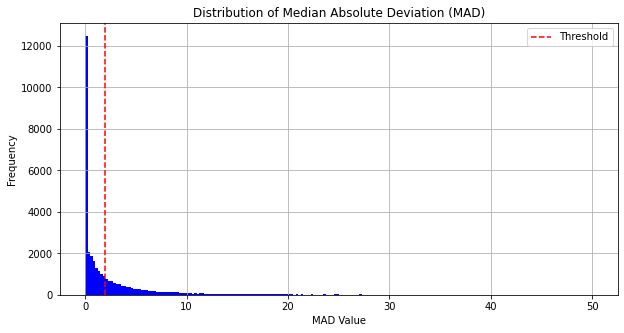

removing 22641 genes under the MAD threshold from the dataset
number of genes selected :  11928
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [3]:
# experiment 1
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 5, 
    gene_selection_file = None)

data_1 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_1 = data_1.shape[1]
data_num_1 = data_1.shape[0]
dat_1 = data_1.reshape(-1,1,feature_num_1)


x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    feature_selection_threshold = 2, 
    gene_selection_file = None)

data_2 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_2 = data_2.shape[1]
data_num_2 = data_2.shape[0]
dat_2 = data_2.reshape(-1,1,feature_num_2)


not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  0 ...
min MAD 0.0
max MAD 2225.368


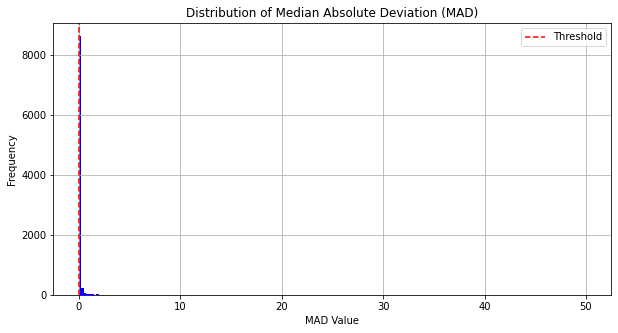

removing 6876 genes under the MAD threshold from the dataset
number of genes selected :  2185
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series
not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
number of genes selected: 2760
retriving symbols for genes
selecting genes based on median absolute deviation threshold:  0 ...
min MAD 0.0
max MAD 3562.5600000000013


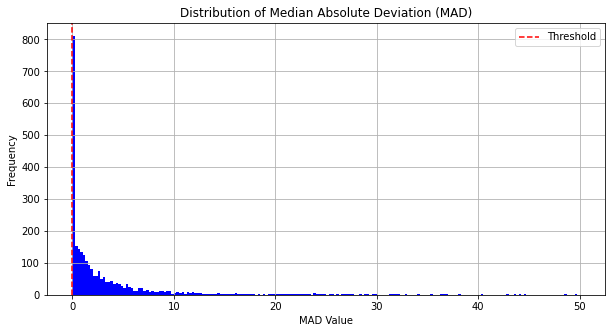

removing 618 genes under the MAD threshold from the dataset
number of genes selected :  2142
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [4]:
# experiment 2
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_1)

data_1 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_1 = data_1.shape[1]
data_num_1 = data_1.shape[0]
dat_1 = data_1.reshape(-1,1,feature_num_1)


x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_1)

data_2 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_2 = data_2.shape[1]
data_num_2 = data_2.shape[0]
dat_2 = data_2.reshape(-1,1,feature_num_2)


not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  0 ...
min MAD 0.0
max MAD 2225.368


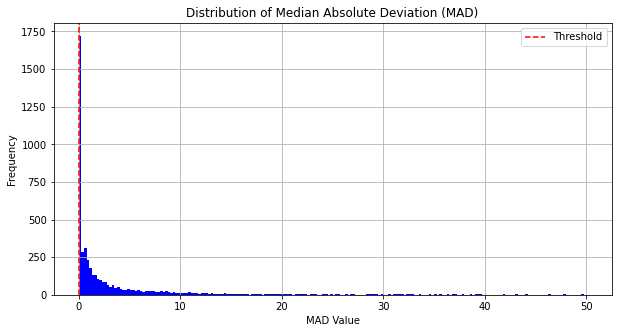

removing 1562 genes under the MAD threshold from the dataset
number of genes selected :  3283
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series
not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
number of genes selected: 1011
retriving symbols for genes
selecting genes based on median absolute deviation threshold:  0 ...
min MAD 0.0
max MAD 2232.9709999999995


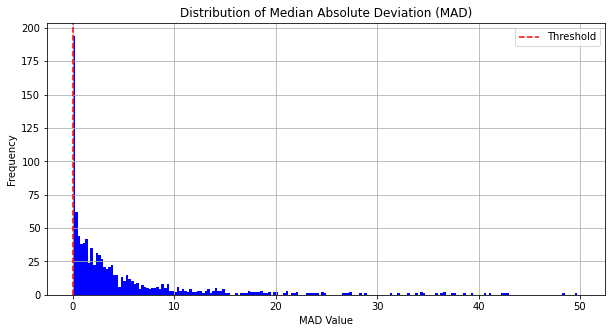

removing 145 genes under the MAD threshold from the dataset
number of genes selected :  866
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [21]:
# experiment 3
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_2)

data_1 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_1 = data_1.shape[1]
data_num_1 = data_1.shape[0]
dat_1 = data_1.reshape(-1,1,feature_num_1)


x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_2)

data_2 = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

feature_num_2 = data_2.shape[1]
data_num_2 = data_2.shape[0]
dat_2 = data_2.reshape(-1,1,feature_num_2)


## End of experiment choice

In [5]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data1, data2 ,transform = None):
        self.transform = transform
        self.data1 = data1
        self.data2 = data2
        self.datanum = len(data1)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data1 = torch.tensor(self.data1[idx]).float()
        out_data2 = torch.tensor(self.data2[idx]).float()
        if self.transform:
            out_data1 = self.transform(out_data1)
            out_data2 = self.transform(out_data2)

        return out_data1,out_data2

In [6]:
train_1, test_1 = train_test_split(dat_1, test_size = 0.1,random_state = 66)
print('train_data_1:',len(train_1))
print('test_data_1:',len(test_1))

train_2, test_2 = train_test_split(dat_2, test_size = 0.1,random_state = 66)
print('train_data_2:',len(train_2))
print('test_data_2:',len(test_2))

train_data_set = Mydatasets(data1 = train_1, data2 = train_2)
test_data_set = Mydatasets(data1 = test_1, data2 = test_2)

train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 64, shuffle=False)

train_data_1: 4000
test_data_1: 445
train_data_2: 4000
test_data_2: 445


In [7]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = rearrange(inputs, 'b c l -> b l c')
        inputs = inputs.contiguous()
        #inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        quantized = rearrange(quantized, 'b c l -> b l c')
        quantized = quantized.contiguous()
        
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        #return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
        return loss, quantized, perplexity, encodings
    
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = rearrange(inputs, 'b c l -> b l c')
        inputs = inputs.contiguous()
        #inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        quantized = rearrange(quantized, 'b c l -> b l c')
        quantized = quantized.contiguous()
        
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
               
        # convert quantized from BHWC -> BCHW
        #return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
        return loss, quantized, perplexity, encodings   

In [8]:
class ResidualStack(nn.Module):
    def __init__(self, encoder_dim):
        super(ResidualStack, self).__init__()
        
        self.block = nn.Sequential(
            nn.Linear(encoder_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, encoder_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        return x + self.block(x)
    
class Encoder(nn.Module):
    def __init__(self, input_size_1, encoder_dim, dropout):
        super(Encoder, self).__init__()

        self.lay1 = nn.Sequential(
            nn.Linear(input_size_1, 2048),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.lay2 = nn.Sequential(
            nn.Linear(2048, encoder_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self._residual_stack = ResidualStack(encoder_dim)

    def forward(self, inputs_1):
        x_1 = self.lay1(inputs_1)
        x_1 = self.lay2(x_1)
        x_1 = self._residual_stack(x_1)
        return x_1

    def forward(self, inputs_2):
        x_1 = self.lay1(inputs_2)
        x_1 = self.lay2(x_1)
        x_1 = self._residual_stack(x_1)
        return x_1

class Decoder(nn.Module):
    def __init__(self, num_embeddings, input_size_1, encoder_dim, dropout):
        super(Decoder, self).__init__()
        
        self.lay0 = nn.Sequential(
            nn.Linear(num_embeddings, encoder_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        self._residual_stack = ResidualStack(encoder_dim)
        
        self.lay1 = nn.Sequential(
            nn.Linear(encoder_dim, 2048),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.lay2 = nn.Sequential(
            nn.Linear(2048, input_size_1),
            nn.GELU(),
            nn.Dropout(dropout)
        )

    def forward(self, inputs):
        x = self.lay0(inputs)
        x = self._residual_stack(x)
        x_1 = self.lay1(x)
        x_1 = self.lay2(x_1)
        return x_1

In [9]:
class Model(nn.Module):
    def __init__(self, num_classes, input_size_1, input_size_2, encoder_dim_b, encoder_dim_t, num_embeddings_b, num_embeddings_t, embedding_dim_b, embedding_dim_t, commitment_cost, dropout, decay=0):
        super(Model, self).__init__()
        
        self._encoder_b = Encoder(input_size_1, encoder_dim_b, dropout)
        self._encoder_b2 = Encoder(input_size_2, encoder_dim_b, dropout)
        self._encoder_t = Encoder(encoder_dim_b, encoder_dim_t, dropout)
        
        self._pre_vq_conv_b = nn.Linear(encoder_dim_b, num_embeddings_b)
        self._pre_vq_conv_t = nn.Linear(encoder_dim_t, num_embeddings_t)
        
        if decay > 0.0:
            self._vq_vae_b = VectorQuantizerEMA(num_embeddings_b, embedding_dim_b, commitment_cost, decay)
            self._vq_vae_t = VectorQuantizerEMA(num_embeddings_t, embedding_dim_t, commitment_cost, decay)
        else:
            self._vq_vae_b = VectorQuantizer(num_embeddings_b, embedding_dim_b, commitment_cost)
            self._vq_vae_t = VectorQuantizer(num_embeddings_t, embedding_dim_t, commitment_cost)
        
        self._upsample = nn.Linear(num_embeddings_t, num_embeddings_b)
        
        self._decoder_t = Decoder(num_embeddings_t, encoder_dim_b, encoder_dim_t, dropout)   
        self._decoder_b = Decoder(num_embeddings_b, input_size_1, encoder_dim_b, dropout)
        self._decoder_b2 = Decoder(num_embeddings_b, input_size_2, encoder_dim_b, dropout)
        

    def forward(self, x1, x2):
        #Top level
        z_b = self._encoder_b(x1)
        z_t = self._encoder_t(z_b)
        z_t = self._pre_vq_conv_t(z_t)
        vq_loss_t, quantized_t, perplexity_t, _ = self._vq_vae_t(z_t)
        recon_t = self._decoder_t(quantized_t)
        
        #Bottom level
        z_b2 = self._encoder_b2(x2)
        z_final = z_b + z_b2 + recon_t
        z_final = self._pre_vq_conv_b(z_final)
        vq_loss_b, quantized_b, perplexity_b, _ = self._vq_vae_b(z_final)
        recon_b = self._decoder_b(quantized_b + self._upsample(quantized_t))
        recon_b2 = self._decoder_b2(quantized_b + self._upsample(quantized_t))
        variance_z_b = torch.var(z_b)
        return vq_loss_b, vq_loss_t, recon_b, recon_b2, recon_t, z_b, z_final, quantized_b, perplexity_b, variance_z_b

## Preping labels

In [10]:
metadata_path = "../../METADATA_200123.xlsx"

meta_data = pd.read_excel(metadata_path, header = 1, usecols = range(1,10) )
patient_ids = [int(name.split(".")[1]) for name in filenames]

# Create a dictionary to map 'Patient Number' to 'Disease Status'
patient_disease_status = dict(zip(meta_data['Patient Number'], meta_data['Disease Status']))

label = [patient_disease_status.get(patient_id, None) for patient_id in patient_ids]
label = pd.Series(label)
num_classes = len(pd.Series(label).unique())

In [11]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("mps")

VQ_VAE = Model(
            dropout = 0.0,
            num_classes = num_classes,
            input_size_1 = feature_num_1,
            input_size_2 = feature_num_2,
            encoder_dim_b = 64,
            encoder_dim_t = 32,
            num_embeddings_b = 64,
            num_embeddings_t = 32,
            embedding_dim_b = 64,
            embedding_dim_t = 32, 
            commitment_cost = 1
           ).to(DEVICE)

Classifier_loss = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(VQ_VAE.parameters(), lr=1e-4, amsgrad=False)
data_variance_1 = np.var(dat_1)
data_variance_2 = np.var(dat_2)

#VQ_VAE.load_state_dict(torch.load('VQ_2_disc'),strict=False)
print(DEVICE)

mps


we need a proper training function


In [ ]:
EPOCH = 500
train_res_recon_error = []
train_res_perplexity = []

loss_list = []
val_loss_list = []
ac_list = []
VQ_VAE.train()

for epoch in tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    quantized_merge = torch.empty(0, 1, 64).to(DEVICE)

    for _, (inputs1, inputs2) in enumerate(train_dataloader, 0):
        optimizer.zero_grad()
        inputs1 = inputs1.to(DEVICE)
        inputs2 = inputs2.to(DEVICE)
        vq_loss_b, vq_loss_t, recon_b, recon_b2, recon_t, z_b, z_final, quantized_b, perplexity, variance_z_b = VQ_VAE(inputs1, inputs2)
        recon_error_b = F.mse_loss(recon_b, inputs1) / data_variance_1
        recon_error_b2 = F.mse_loss(recon_b2, inputs2) / data_variance_2
        recon_error_t = F.mse_loss(recon_t, z_b) / variance_z_b
        loss = recon_error_b + recon_error_b2 + recon_error_t + vq_loss_b + vq_loss_t
        loss.backward()
        optimizer.step()
        count += 1

        # Append the training loss values for monitoring
        train_res_recon_error.append(recon_error_b.item() + recon_error_t.item())
        train_res_perplexity.append(perplexity.item())

        # Print training statistics
        if count % 5 == 0:  # Adjust this frequency as needed
            print(  f'Epoch [{epoch + 1}/{EPOCH}],'
                    f'Recon Error: {recon_error_b.item() + recon_error_t.item():.4f}, '
                    f'Perplexity: {perplexity.item():.4f}')

# After training, you can print or log other relevant information as needed
print('Training completed.')
plt.plot(train_res_recon_error)

In [13]:
en_lat = []
en_quantized = []
en_labels = []

data_set = Mydatasets(data1 = dat_1, data2 = dat_2)
data_set = torch.utils.data.DataLoader(data_set, batch_size = 256, shuffle=True)

for i in range(len(dat_1)):
    en_data1 = data_set.dataset[i][0]
    en_data2 = data_set.dataset[i][1]

    _, _, _, _, _, latent_1, latent_2, _, _, _ = VQ_VAE(en_data1.view(1, 1, feature_num_1).float().to(DEVICE), en_data2.view(1, 1, feature_num_2).float().to(DEVICE))
    en_quantized.append(latent_2.cpu().detach().numpy())
    en_lat.append(latent_1.cpu().detach().numpy())
    en_quantized.append(latent_2.cpu().detach().numpy())

encode_out = np.array(en_lat)
encode_out = encode_out.reshape(len(dat_1), -1)
quantized_out = np.array(en_quantized)
quantized_out = quantized_out.reshape(len(dat_1), -1)
print('encode_out:', encode_out.shape)
print('quantized_out:', quantized_out.shape)

latent_Z = encode_out

encode_out: (4445, 64)
quantized_out: (4445, 128)


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:197: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = axes[1].scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap, c=colors)


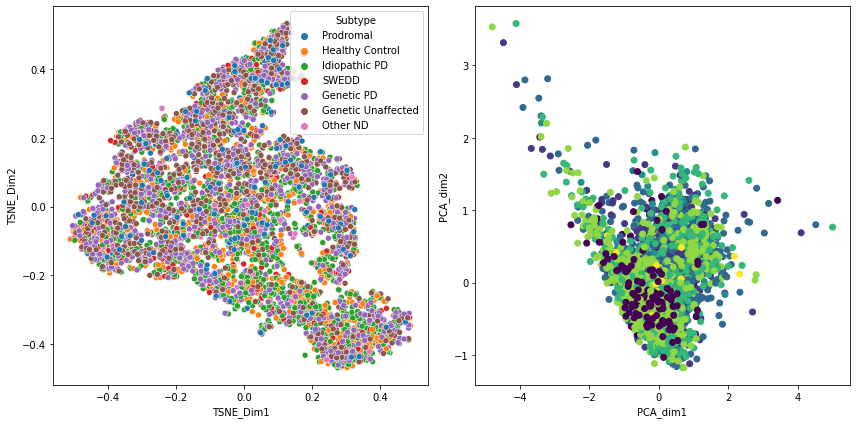

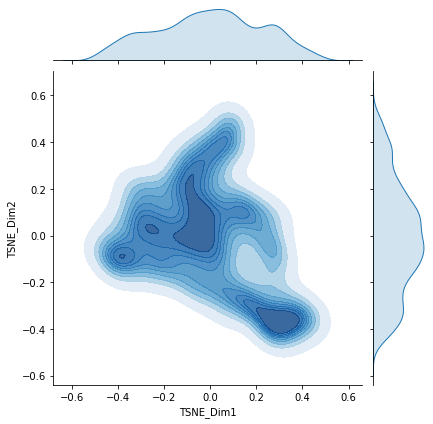

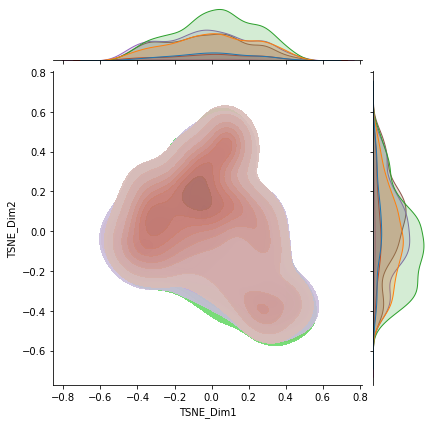

In [21]:
params = {"early_exaggeration":20,
              "learning_rate":500, 
              "perplexity":80, 
              "min_grad_norm":1e-7, 
              "n_iter":10000,
              "n_components":2}
visualisation.plot_clusters(encode_out, label, params)

In [23]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
filenames_mask = filenames_series.str.contains("BL")


# Apply the combined mask to your dataset
filtered_dat = encode_out[filenames_mask]
filtered_clinical_info = clinical_info_series[filenames_mask]

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(1521, 64)
(1521,)


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:197: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = axes[1].scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap, c=colors)


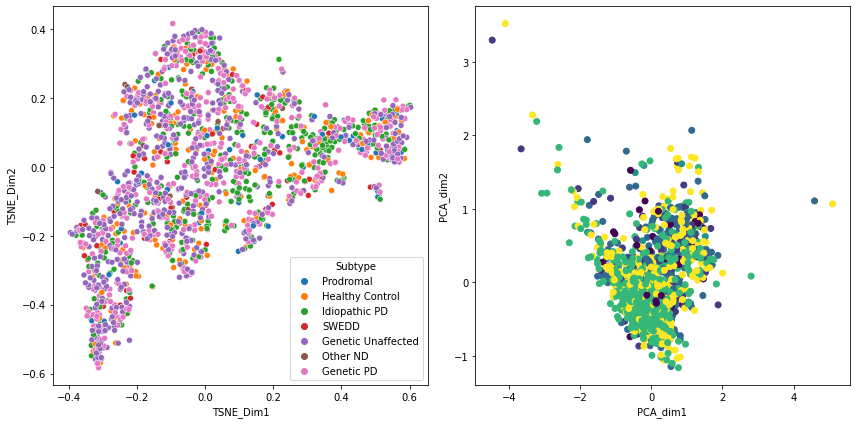

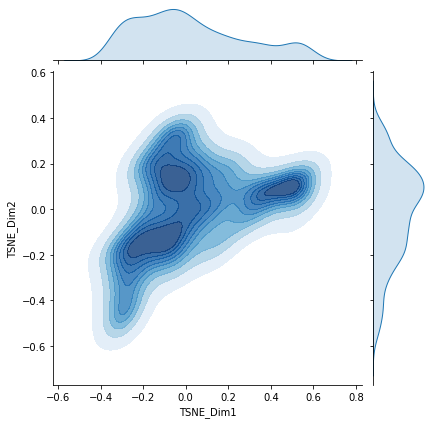

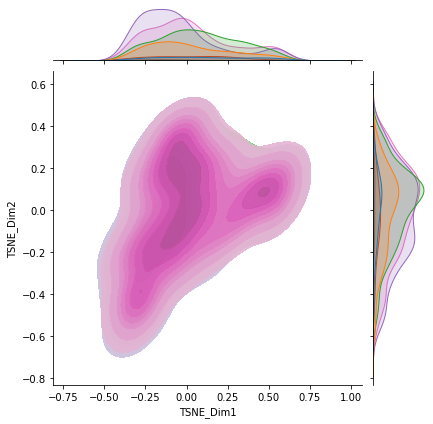

In [24]:
params = {"early_exaggeration":20,
              "learning_rate":500, 
              "perplexity":50, 
              "min_grad_norm":1e-7, 
              "n_iter":5000,
              "n_components":2}
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, params)

In [25]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
#clinical_mask = clinical_info_series == "Genetic PD"
clinical_mask = clinical_info_series == "Idiopathic PD"
filenames_mask = filenames_series.str.contains("BL")

# Combine the masks using logical AND
combined_mask = filenames_mask & clinical_mask

# Apply the combined mask to your dataset

filtered_dat = encode_out[combined_mask]
filtered_clinical_info = clinical_info_series[combined_mask]
filtered_filenames_series = filenames_series[combined_mask] # just to check

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(343, 64)
(343,)


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:197: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = axes[1].scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap, c=colors)


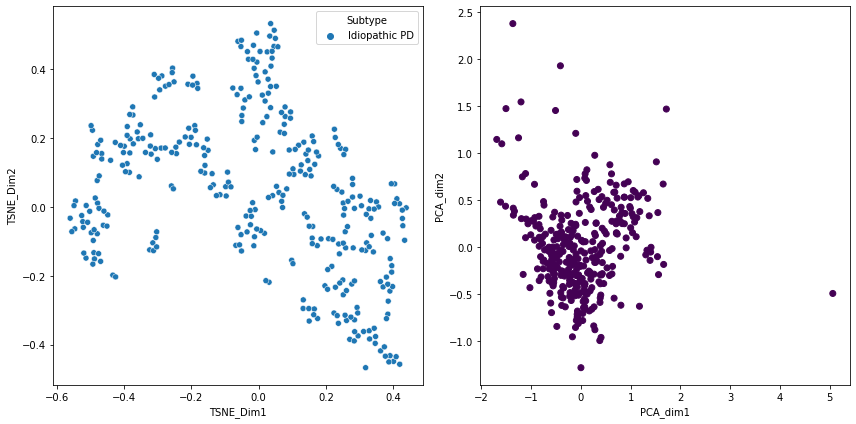

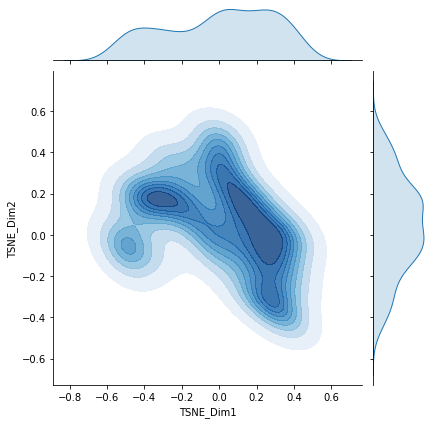

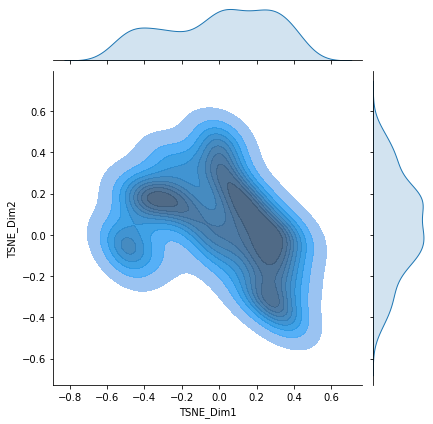

In [31]:
params = {"early_exaggeration":50,
              "learning_rate":100, 
              "perplexity":10, 
              "min_grad_norm":1e-7, 
              "n_iter":5000,
              "n_components":2}
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, params)

In [34]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
#clinical_mask = clinical_info_series == "Genetic PD"
clinical_mask = clinical_info_series == "Idiopathic PD"
filenames_mask = filenames_series.str.contains("BL")

# Combine the masks using logical AND
combined_mask = clinical_mask

# Apply the combined mask to your dataset

filtered_dat = encode_out[combined_mask]
filtered_clinical_info = clinical_info_series[combined_mask]
filtered_filenames_series = filenames_series[combined_mask] # just to check

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(1400, 64)
(1400,)


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:197: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = axes[1].scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap, c=colors)


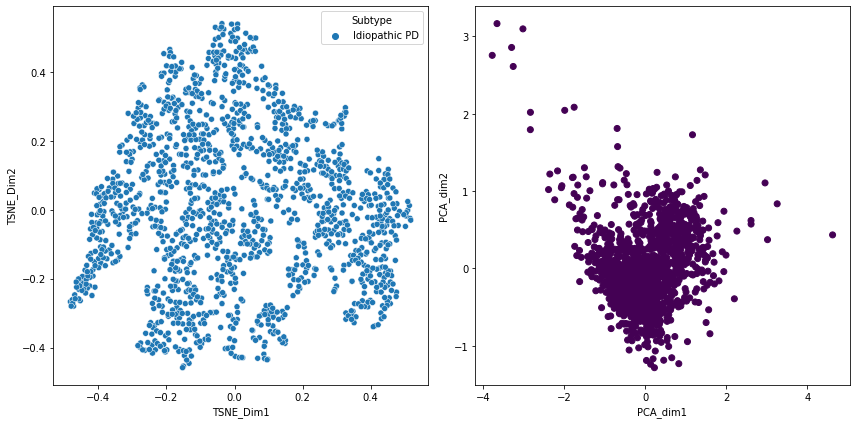

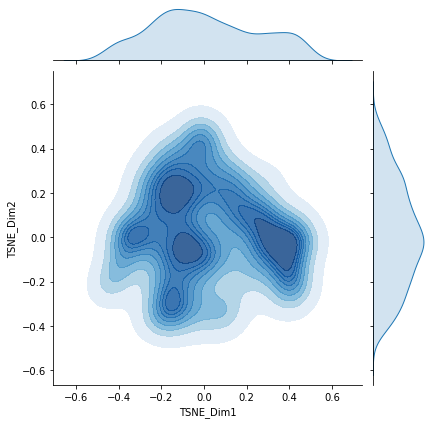

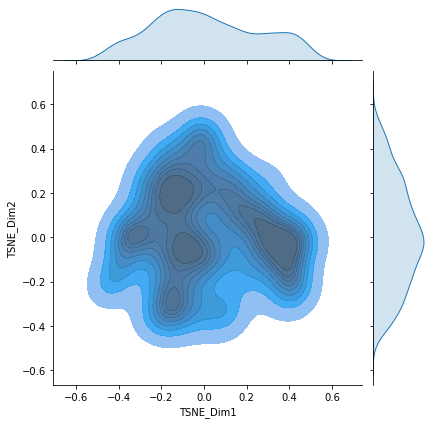

In [36]:
params = {"early_exaggeration":5,
              "learning_rate":100, 
              "perplexity": 35, 
              "min_grad_norm":1e-7, 
              "n_iter":5000,
              "n_components":2}
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, params)